In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-17 06:21:35--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2021-06-17 06:21:35 (12.6 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



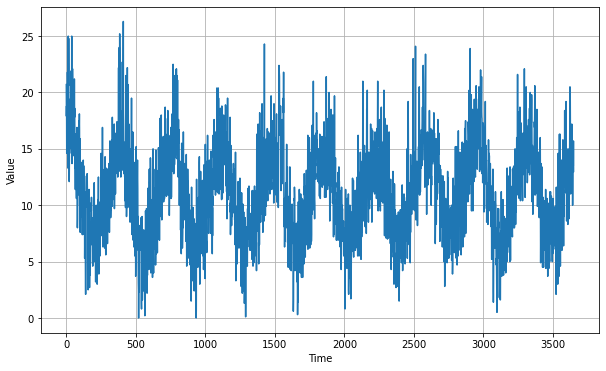

In [4]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile,delimiter=',')
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i)

# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series [:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x: (x[:-1], x[1:]))

  return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x:x.batch(window_size+1))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)

  return forecast
    # YOUR CODE HERE

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding='causal',activation='relu',
                       input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 33s 54ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 1s 47ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 1s 49ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 1s 49ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 1s 51ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 1s 51ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 1s 50ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 1s 51ms/step - loss: 20.6147 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 1s 52ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [==============================] - 1s 51ms/step - loss: 13.6448 - mae: 14.1371
Epoch 11/100
10/10 [========

(1e-08, 0.0001, 0.0, 60.0)

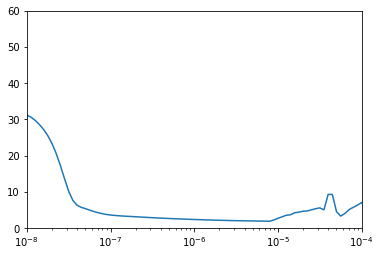

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                       strides=1, padding='causal',activation='relu',
                       input_shape=[None,1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x:x*400)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 5s 37ms/step - loss: 4.9022 - mae: 5.3789
Epoch 2/150
25/25 [==============================] - 1s 36ms/step - loss: 2.1842 - mae: 2.6435
Epoch 3/150
25/25 [==============================] - 1s 37ms/step - loss: 1.8379 - mae: 2.2895
Epoch 4/150
25/25 [==============================] - 1s 36ms/step - loss: 1.7738 - mae: 2.2243
Epoch 5/150
25/25 [==============================] - 1s 35ms/step - loss: 1.7231 - mae: 2.1727
Epoch 6/150
25/25 [==============================] - 1s 36ms/step - loss: 1.6966 - mae: 2.1452
Epoch 7/150
25/25 [==============================] - 1s 36ms/step - loss: 1.6818 - mae: 2.1299
Epoch 8/150
25/25 [==============================] - 1s 36ms/step - loss: 1.6571 - mae: 2.1049
Epoch 9/150
25/25 [==============================] - 1s 36ms/step - loss: 1.6987 - mae: 2.1472
Epoch 10/150
25/25 [==============================] - 1s 36ms/step - loss: 1.6398 - mae: 2.0871
Epoch 11/150
25/25 [=============================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

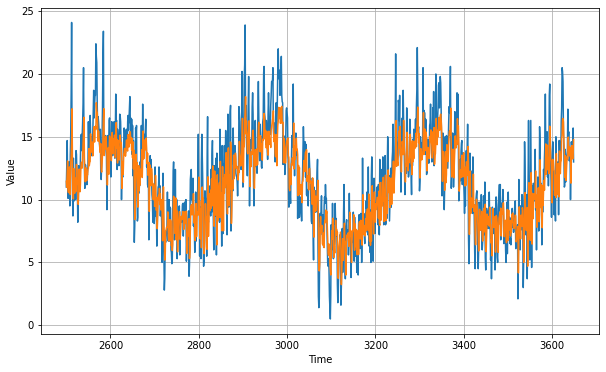

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8379569

In [14]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.456362  10.988319  12.209721  ... 13.232639  13.4786625 14.772529 ]
